# Random Forest Trained on Top 3 Features of Random Forest 

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
from astropy.io import fits
import fitsio
from scipy import stats

import sys, os, warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, KFold

# Load and Prepare Data

In [2]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/spectro/redux/daily/exposures-daily.fits'))
mask = cat['SURVEY']=='main'
mask &= cat['PROGRAM']=='dark'
mask &= cat['EFFTIME_ETC']>100
mask &= cat['EFFTIME_SPEC']>100
mask &= cat['MJD'] != 0
cat = cat[mask]

In [3]:
# We only want to train on g-r

X = np.column_stack([
cat['EBV'],
cat['SEEING_GFA'],
cat['SKY_MAG_G_SPEC']-cat['SKY_MAG_R_SPEC']
])
y = np.column_stack([cat['EFFTIME_SPEC']/cat['EFFTIME_ETC']])
y = np.ravel(y)
X

array([[0.03653126, 1.49983811, 0.53517309],
       [0.01673438, 1.4578289 , 0.63128029],
       [0.01673438, 1.50391999, 0.64071386],
       ...,
       [0.04302216, 0.87274533, 0.75123472],
       [0.00967266, 0.78643645, 0.93714332],
       [0.01626444, 0.85779165, 0.92763987]])

# Train the Random Forest Regressor

### Split the data 50/50 train/test

In [4]:
# Split the training and testing set 50/50
idx_train, idx_test = train_test_split(np.arange(len(cat)), test_size=0.5, random_state=6123)

# Train the random forest
regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
regrf.fit(X[idx_train], y[idx_train])

RandomForestRegressor(max_depth=50, n_estimators=50, n_jobs=4,
                      random_state=1456)

### Results from 50/50 Split

NMAD = 0.07305
Outlier fraction = 20.35%


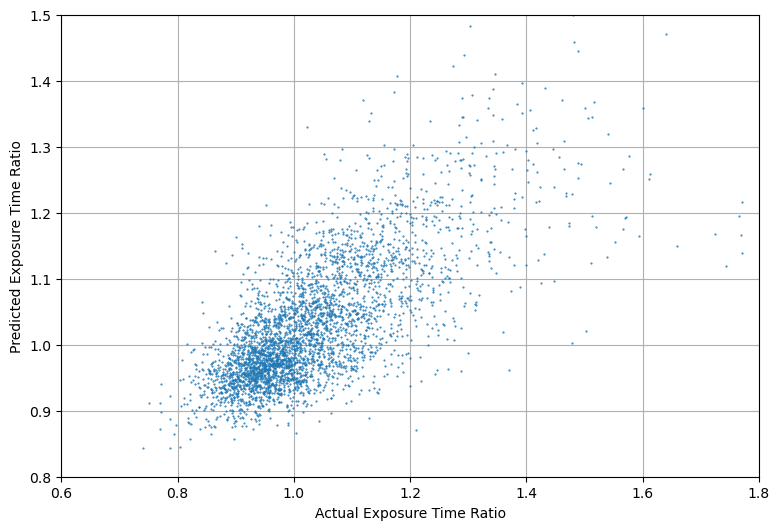

In [5]:
etratio_pred = regrf.predict(X[idx_test])
etratio_actu = y[idx_test]

nmad = 1.48 * np.median(np.abs((etratio_pred - etratio_actu)))
outlier_threshold = 0.1
outlier_frac = np.sum(np.abs((etratio_pred - etratio_actu)) > outlier_threshold)/len(etratio_actu)
print('NMAD = {:.5f}'.format(nmad))
print('Outlier fraction = {:.2f}%'.format(outlier_frac*100))

plt.figure(figsize=(9, 6))
plt.plot(etratio_actu, etratio_pred, '.', markersize=1)
plt.xlabel('Actual Exposure Time Ratio')
plt.ylabel('Predicted Exposure Time Ratio')
plt.axis([0.6, 1.8, 0.8, 1.5])
plt.grid()
plt.show()

### 5 Fold Cross Validation

In [6]:
n_folds = 5
#kf creates the folds
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1456)
np.random.seed(123)
etratio_pred = np.zeros(len(y))

for kf_index, (idx_train, idx_test) in enumerate(kf.split(X)):
# there's a different idx_train and idx_test for each fold
    print('Fold %d'%(kf_index+1))
    regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
    regrf.fit(X[idx_train], y[idx_train])
    etratio_pred[idx_test] = regrf.predict(X[idx_test])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


NMAD = 0.07267
Outlier fraction = 19.24%


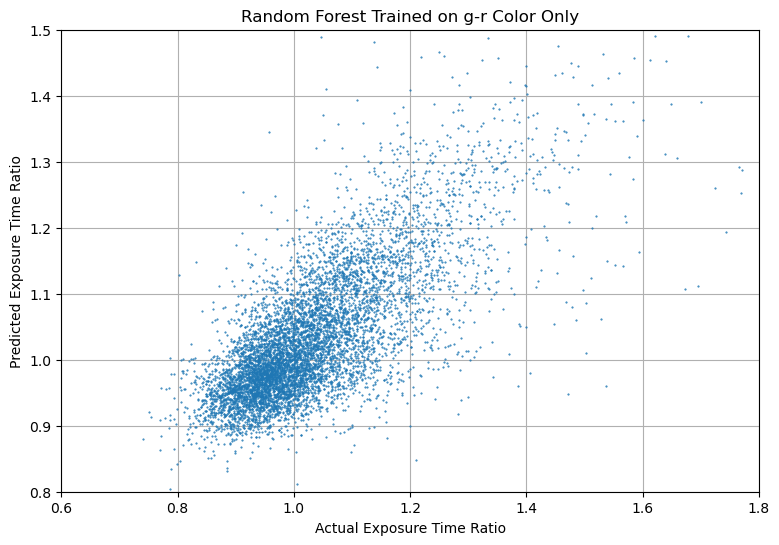

In [7]:
etratio_actu = y

nmad = 1.48 * np.median(np.abs((etratio_pred - etratio_actu)))
outlier_threshold = 0.1
outlier_frac = np.sum(np.abs((etratio_pred - etratio_actu)) > outlier_threshold)/len(etratio_actu)
print('NMAD = {:.5f}'.format(nmad))
print('Outlier fraction = {:.2f}%'.format(outlier_frac*100))

plt.figure(figsize=(9, 6))
plt.plot(etratio_actu, etratio_pred, '.', markersize=1)
plt.title('Random Forest Trained on g-r Color Only')
plt.xlabel('Actual Exposure Time Ratio')
plt.ylabel('Predicted Exposure Time Ratio')
plt.axis([0.6, 1.8, 0.8, 1.5])
plt.grid()
plt.show()

# Optimize Random Forest Corrections

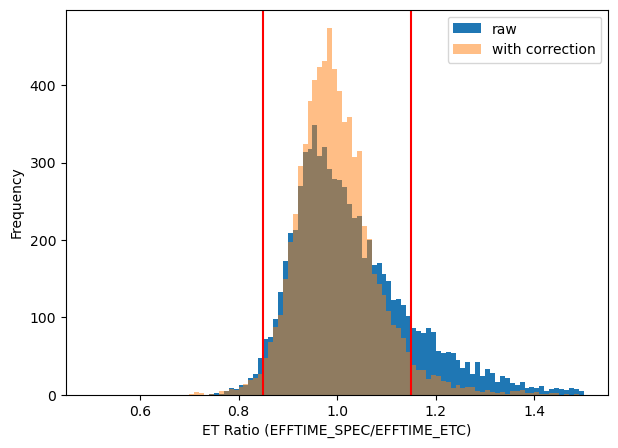

In [8]:
etratio_actu = y
cor_etratio = etratio_actu/etratio_pred

plt.figure(figsize=(7, 5))

plt.hist(etratio_actu,bins = 100,range=(0.5,1.5));
plt.hist(cor_etratio,bins = 100,range=(0.5,1.5), alpha = 0.5);
plt.legend(['raw', 'with correction'])
plt.axvline(0.85, color='r')
plt.axvline(1.15, color='r')


plt.xlabel('ET Ratio (EFFTIME_SPEC/EFFTIME_ETC)')
plt.ylabel('Frequency')

plt.show()

In [9]:

# function that counts the number of data points outside the 0.85-1.15 range in arr
def count_highs(arr):
    return (np.array(arr) > 1.15).sum()/len(arr)

def count_lows(arr):
    return (np.array(arr) < 0.85).sum()/len(arr)

def show_stats(arr, name): # takes in the array and the name of the data
    print('Statistics for', name)
    print('Fraction under 0.85:', count_lows(arr))
    print('Fraction over 1.15:', count_highs(arr))
    print('Median Absolute Deviation:', stats.median_abs_deviation(arr))
    print('Standard Deviation:', np.std(arr))
    print('-------------------------------')
    outliersraw = count_lows(etratio_actu)+count_highs(etratio_actu)
    outliersarr = count_lows(arr) + count_highs(arr)
    print('Outlier %: ', outliersarr*100, '%')
    print('Underexposed < 0.85: ', count_lows(arr)*100, '%')
    print('Reduction in outliers from Raw Data:', outliersraw - outliersarr, "(", (outliersraw-outliersarr)/outliersraw*100,"% less than raw)")
    print('Reduction in MAD from Raw Data:', stats.median_abs_deviation(etratio_actu) - stats.median_abs_deviation(arr), "(", (stats.median_abs_deviation(etratio_actu) - stats.median_abs_deviation(arr))/stats.median_abs_deviation(etratio_actu) *100,"% less than raw)")
    print('Reduction in SD from Raw Data:', np.std(etratio_actu) - np.std(arr), "(", (np.std(etratio_actu) - np.std(arr))/np.std(etratio_actu) *100,"% less than raw)")

    print('-------------------------------')


In [10]:
show_stats(etratio_actu, "Raw Data")
print()
show_stats(etratio_actu/etratio_pred, "Unlimited Correction Data")
print()


Statistics for Raw Data
Fraction under 0.85: 0.019171470706529026
Fraction over 1.15: 0.1563212226840059
Median Absolute Deviation: 0.07020108213838228
Standard Deviation: 0.1330205406150333
-------------------------------
Outlier %:  17.54926933905349 %
Underexposed < 0.85:  1.9171470706529026 %
Reduction in outliers from Raw Data: 0.0 ( 0.0 % less than raw)
Reduction in MAD from Raw Data: 0.0 ( 0.0 % less than raw)
Reduction in SD from Raw Data: 0.0 ( 0.0 % less than raw)
-------------------------------

Statistics for Unlimited Correction Data
Fraction under 0.85: 0.016087947446038343
Fraction over 1.15: 0.04182866335969969
Median Absolute Deviation: 0.04677505330760612
Standard Deviation: 0.08297477981136005
-------------------------------
Outlier %:  5.791661080573803 %
Underexposed < 0.85:  1.6087947446038344 %
Reduction in outliers from Raw Data: 0.11757608258479688 ( 66.99770817417875 % less than raw)
Reduction in MAD from Raw Data: 0.023426028830776158 ( 33.36989704033071 % le